<a href="https://colab.research.google.com/github/Ciss48/IAP_Predict_by_first_banner/blob/main/Predict_IAP_banner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: Đây là bài toán kiểu dự đoán user iap nên bị mất cân bằng dữ liệu, mục tiêu của ta là tìm được càng nhiều iap càng tốt. Nên sau đây sẽ là vài note về đánh giá các chỉ số:
- Accuracy: Chẳng để làm gì vì model cứ dự đoán tất cả là not iap thì accuracy cũng tầm hơn 95% mẹ rồi
- Precision: quan trọng nhưng chưa đủ, precision cao = ít dự đoán nhầm, nhưng nó có thể bỏ sót nhiều user_iap: Ví dụ dự đoán 10/22 iap nhưng chỉ dự đoán nhầm thêm 50/5000 user not iap thành iap
- Recall: quan trọng nhưng chưa đủ, recall cao = dự đoán trúng nhiều user iap nhưng cũng dự đoán nhầm nhiều: Ví dụ bắt được 18/22 user iap nhưng bắt nhầm thêm 500 thằng not iap thành iap
- F1: Cân bằng cả 2, F1 = 2 × (Precision × Recall) / (Precision + Recall)".Chỉ cao khi CẢ precision VÀ recall đều tốt. Phù hợp nếu mục tiêu là tìm được user iap nhưng ko tìm sai quá nhiều

# Import

In [ ]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

project_id = 'crazy-coffee-jam'

from google.colab import auth
auth.authenticate_user()
# Construct a BigQuery client object.
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import BorderlineSMOTE

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Đã import thành công tất cả thư viện!")
print("Phiên bản pandas:", pd.__version__)
print("Phiên bản numpy:", np.__version__)

Đã import thành công tất cả thư viện!
Phiên bản pandas: 2.2.2
Phiên bản numpy: 2.0.2


# Prepare df

In [ ]:
start_date = '2025-06-10'
end_date = '2025-06-30'

In [ ]:
query = f"""
with user_iap as (
  select distinct user_pseudo_id
  FROM `crazy-coffee-jam.flatten_table.in_app_purchase`
  WHERE event_date between '{start_date}' and '{end_date}'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date between '{start_date}' and '{end_date}')
), first_ad_banner_time as (
  select user_pseudo_id, min(event_timestamp) as first_banner_time
  from `crazy-coffee-jam.flatten_table.ad_impression`
  WHERE event_date between '{start_date}' and '{end_date}'
  and ad_format = 'BANNER'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date between '{start_date}' and '{end_date}')
  group by user_pseudo_id
)
select a.user_pseudo_id, b.value as first_ad_banner_value,
 case when a.user_pseudo_id in (select distinct user_pseudo_id from user_iap) then 'iap' else 'not_iap' end as user_label
from first_ad_banner_time a
left join `crazy-coffee-jam.flatten_table.ad_impression` b
on a.user_pseudo_id = b.user_pseudo_id
and a.first_banner_time = b.event_timestamp
"""
df = client.query(query).to_dataframe()
df.drop_duplicates(subset=['user_pseudo_id'], inplace=True)
df

,user_pseudo_id,first_ad_banner_value,user_label
0,dcb2803098b7bd59228612fa59f79c9d,0.000046,not_iap
1,BDA19878ED674B1599C564E1FC9C6FA1,0.000103,not_iap
2,c349d77f2654e410697ce1a4e0ac46d3,0.000112,not_iap
3,9ca01bc9c2f17102cae59552d8353c5c,0.000666,not_iap
4,05c57801d083b41ccc496f2300a2c58c,0.000081,not_iap
...,...,...,...
23665,C2A96D6318734BB18D08B12C2E1243D5,0.000597,not_iap
23666,1b04d092a9657c5d10de5f783fd52b78,0.000252,not_iap
23667,a9b6fd0c06f2bdc230d0ec768b29d802,0.000232,not_iap
23668,724864abe464e6a16ca5bcd49edeb181,0.000025,not_iap


In [ ]:
df['user_label'].value_counts()

,count
user_label,
not_iap,23497
iap,81


# Train model

## Prepare df train

In [ ]:
# Xóa user_pseudo_id vì không cần thiết cho training
df_processed = df.drop('user_pseudo_id', axis=1).copy()

# Xử lý missing values (nếu có)
print("Xử lý missing values...")
df_processed = df_processed.dropna()
print(f"Số dòng sau khi xóa missing values: {len(df_processed)}")

df_processed['target'] = df_processed['user_label'].map({'not_iap': 0, 'iap': 1})

Xử lý missing values...
Số dòng sau khi xóa missing values: 23578


In [ ]:
# Tách features và target
X = df_processed[['first_ad_banner_value']].copy()
y = df_processed['target'].copy()

# Bước 4: Chia tách dữ liệu train/test

# Chia dữ liệu với stratify để giữ tỷ lệ class
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Kết quả chia tách dữ liệu:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Kết quả chia tách dữ liệu:
Training set: 18862 samples
Test set: 4716 samples


In [ ]:
# Bước 5: Xử lý imbalanced data

print("Các phương pháp xử lý imbalanced data:")
print("1. Baseline (không xử lý)")
print("2. SMOTE (Synthetic Minority Oversampling)")
print("3. Random Under Sampling")
print("4. SMOTEENN (kết hợp over và under sampling)")
print("5. Class Weight balancing")
print("6. Tomek Links (Under-sampling kỹ thuật cao)")
print("7. NearMiss (Under-sampling thông minh)")
print("8. Cluster Centroids (Under-sampling bằng KMeans)")
print("9. Borderline-SMOTE (cải tiến của SMOTE)")
# 1. Baseline - giữ nguyên dữ liệu
X_train_baseline = X_train.copy()
y_train_baseline = y_train.copy()

# 2. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 3. Random Under Sampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# 4. SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

# 5. ADASYN (Adaptive Synthetic Sampling)
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# 6. Tomek Links (Under-sampling kỹ thuật cao)
tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)

# 7. NearMiss (Under-sampling thông minh)
nearmiss = NearMiss(version=1)
X_train_nearmiss, y_train_nearmiss = nearmiss.fit_resample(X_train, y_train)

# 8. Cluster Centroids (Under-sampling bằng KMeans)
cc = ClusterCentroids(random_state=42)
X_train_cc, y_train_cc = cc.fit_resample(X_train, y_train)

# 9. Borderline-SMOTE (cải tiến của SMOTE)
bl_smote = BorderlineSMOTE(random_state=42)
X_train_bl_smote, y_train_bl_smote = bl_smote.fit_resample(X_train, y_train)

Các phương pháp xử lý imbalanced data:
1. Baseline (không xử lý)
2. SMOTE (Synthetic Minority Oversampling)
3. Random Under Sampling
4. SMOTEENN (kết hợp over và under sampling)
5. Class Weight balancing
6. Tomek Links (Under-sampling kỹ thuật cao)
7. NearMiss (Under-sampling thông minh)
8. Cluster Centroids (Under-sampling bằng KMeans)
9. Borderline-SMOTE (cải tiến của SMOTE)



📊 So sánh kích thước dataset sau xử lý:


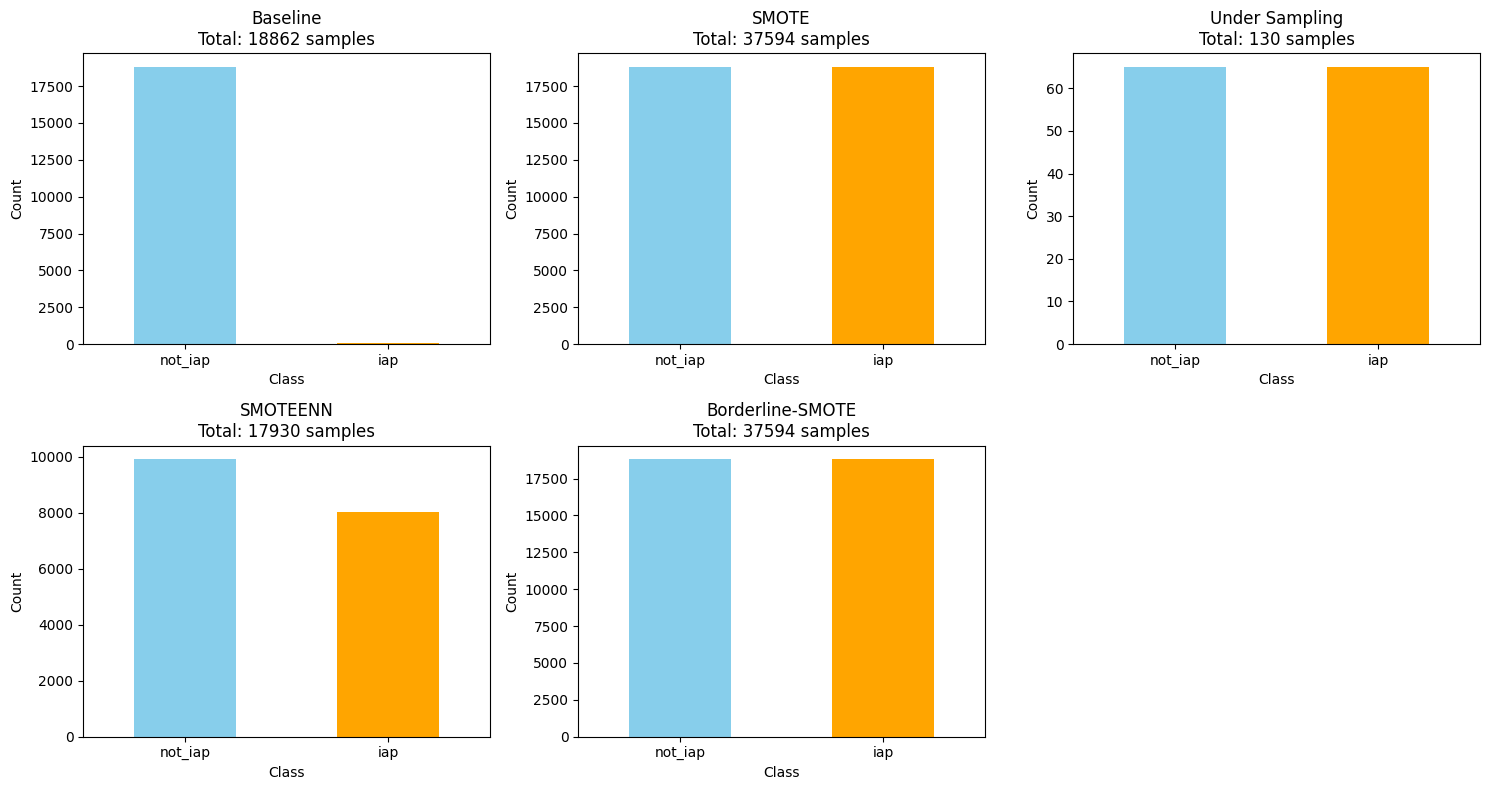


✅ Đã chuẩn bị xong các dataset với 9 phương pháp xử lý imbalance!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ======== Định nghĩa class label (giữ nguyên nếu bạn đang dùng not_iap=0, iap=1) ========
class_labels = {0: 'not_iap', 1: 'iap'}

# ======== Tập hợp tất cả datasets vào dict ========
datasets = {
    'Baseline': (X_train_baseline, y_train_baseline),
    'SMOTE': (X_train_smote, y_train_smote),
    'Under Sampling': (X_train_under, y_train_under),
    'SMOTEENN': (X_train_smoteenn, y_train_smoteenn),
    'Borderline-SMOTE': (X_train_bl_smote, y_train_bl_smote)
}

# ======== In ra thông tin tổng quan từng dataset ========
print("\n📊 So sánh kích thước dataset sau xử lý:")

for name, (X_data, y_data) in datasets.items():
    counts = pd.Series(y_data).value_counts().sort_index()
    for class_val in [0, 1]:
        count = counts.get(class_val, 0)

# ======== Vẽ biểu đồ bar so sánh tỉ lệ class ========
num_datasets = len(datasets)
cols = 3
rows = (num_datasets + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.ravel()

for idx, (name, (X_data, y_data)) in enumerate(datasets.items()):
    counts = pd.Series(y_data).value_counts().sort_index()
    counts.index = [class_labels.get(i, str(i)) for i in counts.index]

    counts.plot(kind='bar', ax=axes[idx], color=['skyblue', 'orange'])
    axes[idx].set_title(f'{name}\nTotal: {len(y_data)} samples')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticklabels(counts.index, rotation=0)

# Ẩn subplot thừa (nếu có)
for idx in range(num_datasets, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

print("\n✅ Đã chuẩn bị xong các dataset với 9 phương pháp xử lý imbalance!")


## Train model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Tạo dictionary chứa mô hình
models = {}

# Danh sách các tham số mặc định
default_params = {
    "random_state": 42,
    "max_depth": 5,
    "min_samples_split": 10,
    "min_samples_leaf": 5
}

# 1. Baseline
models['Baseline'] = DecisionTreeClassifier(**default_params)

# 2. SMOTE
models['SMOTE'] = DecisionTreeClassifier(**default_params)

# 3. Under Sampling (tùy chỉnh nhẹ)
models['Under Sampling'] = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2
)

# 4. SMOTEENN
models['SMOTEENN'] = DecisionTreeClassifier(**default_params)

# 9. Borderline-SMOTE
models['Borderline-SMOTE'] = DecisionTreeClassifier(**default_params)

# 10. Class Weight Balanced
models['Class Weight Balanced'] = DecisionTreeClassifier(
    **default_params,
    class_weight='balanced'
)

# 11. Class Weight Custom
models['Class Weight Custom'] = DecisionTreeClassifier(
    **default_params,
    class_weight={0: 1, 1: 650}
)

In [ ]:
# Mapping dataset với tên model tương ứng
dataset_map = {
    'Baseline': (X_train_baseline, y_train_baseline),
    'SMOTE': (X_train_smote, y_train_smote),
    'Under Sampling': (X_train_under, y_train_under),
    'SMOTEENN': (X_train_smoteenn, y_train_smoteenn),
    'Borderline-SMOTE': (X_train_bl_smote, y_train_bl_smote),
    # Hai mô hình cuối dùng cùng 1 dữ liệu baseline
    'Class Weight Balanced': (X_train_baseline, y_train_baseline),
    'Class Weight Custom': (X_train_baseline, y_train_baseline)
}

# Huấn luyện tất cả mô hình
print("Đang huấn luyện các models...")

for name, model in models.items():
    X_train, y_train = dataset_map[name]
    model.fit(X_train, y_train)

print("✅ Đã huấn luyện xong tất cả mô hình.")


Đang huấn luyện các models...
✅ Đã huấn luyện xong tất cả mô hình.


### Optimize class weight by f1

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from collections import Counter

def check_class_distribution(y):
    """Kiểm tra phân phối class"""
    counter = Counter(y)
    total = len(y)
    print("Class Distribution:")
    for class_label, count in counter.items():
        percentage = (count / total) * 100
        print(f"  Class {class_label}: {count} samples ({percentage:.2f}%)")

    imbalance_ratio = counter[0] / counter[1] if counter[1] > 0 else float('inf')
    print(f"  Imbalance ratio (class 0 : class 1) = {imbalance_ratio:.1f} : 1")
    return counter

def method1_smart_grid_search(X_train, y_train, cv_folds=5):
    """
    Phương pháp 1: Smart Grid Search - Tối ưu cho dữ liệu imbalanced
    """
    print("=" * 60)
    print("PHƯƠNG PHÁP 1: SMART GRID SEARCH")
    print("=" * 60)

    # Kiểm tra class distribution
    class_counts = check_class_distribution(y_train)

    # Tính toán range weight thông minh dựa trên imbalance ratio
    imbalance_ratio = class_counts[0] / class_counts[1]

    # Tạo range weight từ 1 đến 3x imbalance ratio
    max_weight = min(int(imbalance_ratio * 3), 1000)  # Giới hạn max = 1000
    weight_1_values = [1, 2, 5, 10, 20, 30, 50]

    # Thêm các giá trị xung quanh imbalance ratio
    around_ratio = [int(imbalance_ratio * 0.5), int(imbalance_ratio),
                   int(imbalance_ratio * 1.5), int(imbalance_ratio * 2)]
    weight_1_values.extend(around_ratio)

    # Thêm range cao hơn nếu cần
    if max_weight > 50:
        weight_1_values.extend([100, 150, 200, 300, 500])
        if max_weight > 500:
            weight_1_values.extend([750, 1000])

    # Remove duplicates và sort
    weight_1_values = sorted(list(set([w for w in weight_1_values if w <= max_weight])))

    print(f"\nTesting weights for class 1: {weight_1_values}")
    print(f"Total combinations to test: {len(weight_1_values)}")

    best_f1 = 0
    best_weights = None
    best_model = None
    results = []

    # Cross-validation setup
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    print("\nTesting class weights:")
    print("-" * 50)

    for weight_1 in weight_1_values:
        class_weight = {0: 1, 1: weight_1}

        # Tạo model
        model = DecisionTreeClassifier(
            random_state=42,
            max_depth=5,
            min_samples_split=10,
            min_samples_leaf=5,
            class_weight=class_weight
        )

        # Cross-validation F1 scores
        try:
            f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
            mean_f1 = f1_scores.mean()
            std_f1 = f1_scores.std()

            results.append({
                'weight_1': weight_1,
                'mean_f1': mean_f1,
                'std_f1': std_f1,
                'f1_scores': f1_scores
            })

            print(f"Weight {{0:1, 1:{weight_1:3d}}} - F1: {mean_f1:.4f} (±{std_f1:.4f})")

            if mean_f1 > best_f1:
                best_f1 = mean_f1
                best_weights = class_weight
                best_model = model

        except Exception as e:
            print(f"Weight {{0:1, 1:{weight_1:3d}}} - Error: {str(e)}")

    print(f"\n🏆 BEST RESULT:")
    print(f"   Best weights: {best_weights}")
    print(f"   Best CV F1 Score: {best_f1:.4f}")

    # Fit model với best weights
    if best_model:
        best_model.fit(X_train, y_train)

        # Test trên training set để xem confusion matrix
        y_pred_train = best_model.predict(X_train)
        print(f"\n📊 Performance on training set:")
        print(f"   Training F1: {f1_score(y_train, y_pred_train):.4f}")
        print(f"   Confusion Matrix:")
        print(confusion_matrix(y_train, y_pred_train))

    return best_model, best_weights, results

def method2_iterative_optimization(X_train, y_train, cv_folds=5):
    """
    Phương pháp 2: Iterative Optimization - Tìm kiếm thông minh
    """
    print("=" * 60)
    print("PHƯƠNG PHÁP 2: ITERATIVE OPTIMIZATION")
    print("=" * 60)

    # Kiểm tra class distribution
    class_counts = check_class_distribution(y_train)
    imbalance_ratio = class_counts[0] / class_counts[1]

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    def evaluate_weight(weight_1):
        """Đánh giá một weight value"""
        class_weight = {0: 1, 1: weight_1}
        model = DecisionTreeClassifier(
            random_state=42,
            max_depth=5,
            min_samples_split=10,
            min_samples_leaf=5,
            class_weight=class_weight
        )

        try:
            f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
            return f1_scores.mean(), f1_scores.std(), model
        except:
            return 0, 0, model

    # Bước 1: Tìm kiếm thô (coarse search)
    print("\n🔍 Step 1: Coarse Search")
    coarse_range = [1, 5, 10, 20, 50, 100, 200, 500]
    if imbalance_ratio > 100:
        coarse_range.extend([1000, 2000])

    best_f1 = 0
    best_weight = 1
    coarse_results = []

    for weight in coarse_range:
        f1_mean, f1_std, model = evaluate_weight(weight)
        coarse_results.append((weight, f1_mean, f1_std))
        print(f"   Weight {weight:4d}: F1 = {f1_mean:.4f} (±{f1_std:.4f})")

        if f1_mean > best_f1:
            best_f1 = f1_mean
            best_weight = weight

    print(f"\n   Best coarse weight: {best_weight} (F1 = {best_f1:.4f})")

    # Bước 2: Tìm kiếm tinh (fine search) xung quanh best weight
    print(f"\n🎯 Step 2: Fine Search around {best_weight}")

    # Tạo fine range xung quanh best weight
    if best_weight <= 10:
        fine_range = list(range(max(1, best_weight-3), best_weight+4))
    elif best_weight <= 50:
        fine_range = list(range(max(1, best_weight-10), best_weight+11, 2))
    elif best_weight <= 200:
        fine_range = list(range(max(1, best_weight-30), best_weight+31, 5))
    else:
        fine_range = list(range(max(1, best_weight-100), best_weight+101, 20))

    # Remove duplicates và sort
    fine_range = sorted(list(set(fine_range)))

    fine_best_f1 = 0
    fine_best_weight = best_weight
    fine_best_model = None

    for weight in fine_range:
        f1_mean, f1_std, model = evaluate_weight(weight)
        print(f"   Weight {weight:4d}: F1 = {f1_mean:.4f} (±{f1_std:.4f})")

        if f1_mean > fine_best_f1:
            fine_best_f1 = f1_mean
            fine_best_weight = weight
            fine_best_model = model

    # Kết quả cuối cùng
    final_weights = {0: 1, 1: fine_best_weight}

    print(f"\n🏆 FINAL RESULT:")
    print(f"   Optimal weights: {final_weights}")
    print(f"   Best CV F1 Score: {fine_best_f1:.4f}")

    # Fit model và test
    if fine_best_model:
        fine_best_model.fit(X_train, y_train)
        y_pred_train = fine_best_model.predict(X_train)

        print(f"\n📊 Performance on training set:")
        print(f"   Training F1: {f1_score(y_train, y_pred_train):.4f}")
        print(f"   Confusion Matrix:")
        print(confusion_matrix(y_train, y_pred_train))

        # Detailed classification report
        print(f"\n📋 Classification Report:")
        print(classification_report(y_train, y_pred_train))

    return fine_best_model, final_weights, fine_best_f1

# Hàm chính - sử dụng đơn giản
def optimize_class_weight_for_f1(X_train, y_train, method='both'):
    """
    Hàm chính để tối ưu class weight cho F1 score trên dữ liệu imbalanced

    Parameters:
    - method: 'method1', 'method2', hoặc 'both'
    """

    if method == 'method1' or method == 'both':
        print("🚀 Chạy Method 1: Smart Grid Search")
        model1, weights1, results1 = method1_smart_grid_search(X_train, y_train)

        if method == 'method1':
            return model1, weights1, results1

    if method == 'method2' or method == 'both':
        print("\n🚀 Chạy Method 2: Iterative Optimization")
        model2, weights2, f1_2 = method2_iterative_optimization(X_train, y_train)

        if method == 'method2':
            return model2, weights2, f1_2

    if method == 'both':
        # So sánh 2 phương pháp
        print("\n" + "="*60)
        print("COMPARISON OF METHODS")
        print("="*60)

        # Test cả 2 models
        model1.fit(X_train, y_train)
        model2.fit(X_train, y_train)

        y_pred1 = model1.predict(X_train)
        y_pred2 = model2.predict(X_train)

        f1_1 = f1_score(y_train, y_pred1)
        f1_2 = f1_score(y_train, y_pred2)

        print(f"Method 1 - Weights: {weights1}, F1: {f1_1:.4f}")
        print(f"Method 2 - Weights: {weights2}, F1: {f1_2:.4f}")

        if f1_1 >= f1_2:
            print(f"\n🏆 Winner: Method 1")
            return model1, weights1, results1
        else:
            print(f"\n🏆 Winner: Method 2")
            return model2, weights2, f1_2

# ===== CÁCH SỬ DỤNG =====
"""
# Cách 1: Chạy cả 2 phương pháp và chọn tốt nhất
best_model, best_weights, results = optimize_class_weight_for_f1(
    X_train_baseline, y_train_baseline,
    method='both'
)

# Cách 2: Chỉ chạy 1 phương pháp
best_model, best_weights, results = optimize_class_weight_for_f1(
    X_train_baseline, y_train_baseline,
    method='method2'  # hoặc 'method1'
)

# Cập nhật model
models['Class Weight Optimized'] = best_model
print(f"Final optimal weights: {best_weights}")
"""

'\n# Cách 1: Chạy cả 2 phương pháp và chọn tốt nhất\nbest_model, best_weights, results = optimize_class_weight_for_f1(\n    X_train_baseline, y_train_baseline,\n    method=\'both\'\n)\n\n# Cách 2: Chỉ chạy 1 phương pháp\nbest_model, best_weights, results = optimize_class_weight_for_f1(\n    X_train_baseline, y_train_baseline,\n    method=\'method2\'  # hoặc \'method1\'\n)\n\n# Cập nhật model\nmodels[\'Class Weight Optimized\'] = best_model\nprint(f"Final optimal weights: {best_weights}")\n'

In [ ]:
# Cách 1: Chạy cả 2 phương pháp và chọn tốt nhất
best_model_f1, best_weights, results = optimize_class_weight_for_f1(
    X_train_baseline, y_train_baseline,
    method='both'
)


🚀 Chạy Method 1: Smart Grid Search
PHƯƠNG PHÁP 1: SMART GRID SEARCH
Class Distribution:
  Class 0: 18797 samples (99.66%)
  Class 1: 65 samples (0.34%)
  Imbalance ratio (class 0 : class 1) = 289.2 : 1

Testing weights for class 1: [1, 2, 5, 10, 20, 30, 50, 100, 144, 150, 200, 289, 300, 433, 500, 578, 750]
Total combinations to test: 17

Testing class weights:
--------------------------------------------------
Weight {0:1, 1:  1} - F1: 0.0000 (±0.0000)
Weight {0:1, 1:  2} - F1: 0.0000 (±0.0000)
Weight {0:1, 1:  5} - F1: 0.0000 (±0.0000)
Weight {0:1, 1: 10} - F1: 0.0000 (±0.0000)
Weight {0:1, 1: 20} - F1: 0.0000 (±0.0000)
Weight {0:1, 1: 30} - F1: 0.0000 (±0.0000)
Weight {0:1, 1: 50} - F1: 0.0133 (±0.0175)
Weight {0:1, 1:100} - F1: 0.0268 (±0.0040)
Weight {0:1, 1:144} - F1: 0.0267 (±0.0080)
Weight {0:1, 1:150} - F1: 0.0267 (±0.0080)
Weight {0:1, 1:200} - F1: 0.0251 (±0.0093)
Weight {0:1, 1:289} - F1: 0.0126 (±0.0009)
Weight {0:1, 1:300} - F1: 0.0125 (±0.0009)
Weight {0:1, 1:433} - F1: 0

In [ ]:
# Cập nhật model
models['Class Weight Optimized_f1'] = best_model_f1
print(f"Final optimal weights: {best_weights}")

Final optimal weights: {0: 1, 1: 80}


### by recall

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import recall_score, classification_report, confusion_matrix
from collections import Counter

def check_class_distribution(y):
    """Kiểm tra phân phối class"""
    counter = Counter(y)
    total = len(y)
    print("Class Distribution:")
    for class_label, count in counter.items():
        percentage = (count / total) * 100
        print(f"  Class {class_label}: {count} samples ({percentage:.2f}%)")

    imbalance_ratio = counter[0] / counter[1] if counter[1] > 0 else float('inf')
    print(f"  Imbalance ratio (class 0 : class 1) = {imbalance_ratio:.1f} : 1")
    return counter

def method1_smart_grid_search(X_train, y_train, cv_folds=5):
    print("=" * 60)
    print("PHƯƠNG PHÁP 1: SMART GRID SEARCH")
    print("=" * 60)

    class_counts = check_class_distribution(y_train)
    imbalance_ratio = class_counts[0] / class_counts[1]

    max_weight = min(int(imbalance_ratio * 3), 1000)
    weight_1_values = [1, 2, 5, 10, 20, 30, 50]
    around_ratio = [int(imbalance_ratio * 0.5), int(imbalance_ratio), int(imbalance_ratio * 1.5), int(imbalance_ratio * 2)]
    weight_1_values.extend(around_ratio)

    if max_weight > 50:
        weight_1_values.extend([100, 150, 200, 300, 500])
        if max_weight > 500:
            weight_1_values.extend([750, 1000])

    weight_1_values = sorted(list(set([w for w in weight_1_values if w <= max_weight])))

    print(f"\nTesting weights for class 1: {weight_1_values}")
    print(f"Total combinations to test: {len(weight_1_values)}")

    best_recall = 0
    best_weights = None
    best_model = None
    results = []

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    print("\nTesting class weights:")
    print("-" * 50)

    for weight_1 in weight_1_values:
        class_weight = {0: 1, 1: weight_1}
        model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=10, min_samples_leaf=5, class_weight=class_weight)

        try:
            recall_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
            mean_recall = recall_scores.mean()
            std_recall = recall_scores.std()

            results.append({
                'weight_1': weight_1,
                'mean_recall': mean_recall,
                'std_recall': std_recall,
                'recall_scores': recall_scores
            })

            print(f"Weight {{0:1, 1:{weight_1:3d}}} - Recall: {mean_recall:.4f} (±{std_recall:.4f})")

            if mean_recall > best_recall:
                best_recall = mean_recall
                best_weights = class_weight
                best_model = model

        except Exception as e:
            print(f"Weight {{0:1, 1:{weight_1:3d}}} - Error: {str(e)}")

    print(f"\n\U0001F3C6 BEST RESULT:")
    print(f"   Best weights: {best_weights}")
    print(f"   Best CV Recall: {best_recall:.4f}")

    if best_model:
        best_model.fit(X_train, y_train)
        y_pred_train = best_model.predict(X_train)
        print(f"\n\U0001F4CA Performance on training set:")
        print(f"   Training Recall: {recall_score(y_train, y_pred_train):.4f}")
        print("   Confusion Matrix:")
        print(confusion_matrix(y_train, y_pred_train))

    return best_model, best_weights, results

def method2_iterative_optimization(X_train, y_train, cv_folds=5):
    print("=" * 60)
    print("PHƯƠNG PHÁP 2: ITERATIVE OPTIMIZATION")
    print("=" * 60)

    class_counts = check_class_distribution(y_train)
    imbalance_ratio = class_counts[0] / class_counts[1]
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    def evaluate_weight(weight_1):
        class_weight = {0: 1, 1: weight_1}
        model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=10, min_samples_leaf=5, class_weight=class_weight)

        try:
            recall_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
            return recall_scores.mean(), recall_scores.std(), model
        except:
            return 0, 0, model

    print("\n\U0001F50D Step 1: Coarse Search")
    coarse_range = [1, 5, 10, 20, 50, 100, 200, 500]
    if imbalance_ratio > 100:
        coarse_range.extend([1000, 2000])

    best_recall = 0
    best_weight = 1
    coarse_results = []

    for weight in coarse_range:
        recall_mean, recall_std, model = evaluate_weight(weight)
        coarse_results.append((weight, recall_mean, recall_std))
        print(f"   Weight {weight:4d}: Recall = {recall_mean:.4f} (±{recall_std:.4f})")

        if recall_mean > best_recall:
            best_recall = recall_mean
            best_weight = weight

    print(f"\n   Best coarse weight: {best_weight} (Recall = {best_recall:.4f})")

    print(f"\n\U0001F3AF Step 2: Fine Search around {best_weight}")
    if best_weight <= 10:
        fine_range = list(range(max(1, best_weight-3), best_weight+4))
    elif best_weight <= 50:
        fine_range = list(range(max(1, best_weight-10), best_weight+11, 2))
    elif best_weight <= 200:
        fine_range = list(range(max(1, best_weight-30), best_weight+31, 5))
    else:
        fine_range = list(range(max(1, best_weight-100), best_weight+101, 20))

    fine_range = sorted(list(set(fine_range)))

    fine_best_recall = 0
    fine_best_weight = best_weight
    fine_best_model = None

    for weight in fine_range:
        recall_mean, recall_std, model = evaluate_weight(weight)
        print(f"   Weight {weight:4d}: Recall = {recall_mean:.4f} (±{recall_std:.4f})")

        if recall_mean > fine_best_recall:
            fine_best_recall = recall_mean
            fine_best_weight = weight
            fine_best_model = model

    final_weights = {0: 1, 1: fine_best_weight}

    print(f"\n\U0001F3C6 FINAL RESULT:")
    print(f"   Optimal weights: {final_weights}")
    print(f"   Best CV Recall: {fine_best_recall:.4f}")

    if fine_best_model:
        fine_best_model.fit(X_train, y_train)
        y_pred_train = fine_best_model.predict(X_train)
        print(f"\n\U0001F4CA Performance on training set:")
        print(f"   Training Recall: {recall_score(y_train, y_pred_train):.4f}")
        print("   Confusion Matrix:")
        print(confusion_matrix(y_train, y_pred_train))
        print("\n\U0001F4CB Classification Report:")
        print(classification_report(y_train, y_pred_train))

    return fine_best_model, final_weights, fine_best_recall

def optimize_class_weight_for_recall(X_train, y_train, method='both'):
    if method == 'method1' or method == 'both':
        print("\U0001F680 Chạy Method 1: Smart Grid Search")
        model1, weights1, results1 = method1_smart_grid_search(X_train, y_train)
        if method == 'method1':
            return model1, weights1, results1

    if method == 'method2' or method == 'both':
        print("\n\U0001F680 Chạy Method 2: Iterative Optimization")
        model2, weights2, recall_2 = method2_iterative_optimization(X_train, y_train)
        if method == 'method2':
            return model2, weights2, recall_2

    if method == 'both':
        print("\n" + "="*60)
        print("COMPARISON OF METHODS")
        print("="*60)

        model1.fit(X_train, y_train)
        model2.fit(X_train, y_train)

        y_pred1 = model1.predict(X_train)
        y_pred2 = model2.predict(X_train)

        recall_1 = recall_score(y_train, y_pred1)
        recall_2 = recall_score(y_train, y_pred2)

        print(f"Method 1 - Weights: {weights1}, Recall: {recall_1:.4f}")
        print(f"Method 2 - Weights: {weights2}, Recall: {recall_2:.4f}")

        if recall_1 >= recall_2:
            print(f"\n\U0001F3C6 Winner: Method 1")
            return model1, weights1, results1
        else:
            print(f"\n\U0001F3C6 Winner: Method 2")
            return model2, weights2, recall_2


In [ ]:
best_model_recall, weights_recall, results = optimize_class_weight_for_recall(X_train, y_train, method='both')


🚀 Chạy Method 1: Smart Grid Search
PHƯƠNG PHÁP 1: SMART GRID SEARCH
Class Distribution:
  Class 0: 18797 samples (99.66%)
  Class 1: 65 samples (0.34%)
  Imbalance ratio (class 0 : class 1) = 289.2 : 1

Testing weights for class 1: [1, 2, 5, 10, 20, 30, 50, 100, 144, 150, 200, 289, 300, 433, 500, 578, 750]
Total combinations to test: 17

Testing class weights:
--------------------------------------------------
Weight {0:1, 1:  1} - Recall: 0.0000 (±0.0000)
Weight {0:1, 1:  2} - Recall: 0.0000 (±0.0000)
Weight {0:1, 1:  5} - Recall: 0.0000 (±0.0000)
Weight {0:1, 1: 10} - Recall: 0.0000 (±0.0000)
Weight {0:1, 1: 20} - Recall: 0.0000 (±0.0000)
Weight {0:1, 1: 30} - Recall: 0.0000 (±0.0000)
Weight {0:1, 1: 50} - Recall: 0.0615 (±0.0897)
Weight {0:1, 1:100} - Recall: 0.2923 (±0.0897)
Weight {0:1, 1:144} - Recall: 0.3231 (±0.0897)
Weight {0:1, 1:150} - Recall: 0.3231 (±0.0897)
Weight {0:1, 1:200} - Recall: 0.3231 (±0.0897)
Weight {0:1, 1:289} - Recall: 0.7077 (±0.1713)
Weight {0:1, 1:300} - 

In [ ]:
# Cập nhật model
models['Class Weight Optimized Recall'] = best_model_recall
print(f"Final optimal weights: {weights_recall}")

Final optimal weights: {0: 1, 1: 1900}


## Regard model

In [ ]:
# Hiển thị thông tin về decision trees
for name, model in models.items():
    print(f"\n{name} Decision Tree:")
    print(f"  Depth: {model.get_depth()}")
    print(f"  Number of leaves: {model.get_n_leaves()}")
    print(f"  Feature importance: {model.feature_importances_[0]:.4f}")


Baseline Decision Tree:
  Depth: 5
  Number of leaves: 14
  Feature importance: 1.0000

SMOTE Decision Tree:
  Depth: 5
  Number of leaves: 21
  Feature importance: 1.0000

Under Sampling Decision Tree:
  Depth: 5
  Number of leaves: 14
  Feature importance: 1.0000

SMOTEENN Decision Tree:
  Depth: 5
  Number of leaves: 20
  Feature importance: 1.0000

Borderline-SMOTE Decision Tree:
  Depth: 5
  Number of leaves: 22
  Feature importance: 1.0000

Class Weight Balanced Decision Tree:
  Depth: 5
  Number of leaves: 19
  Feature importance: 1.0000

Class Weight Custom Decision Tree:
  Depth: 5
  Number of leaves: 17
  Feature importance: 1.0000

Class Weight Optimized_f1 Decision Tree:
  Depth: 5
  Number of leaves: 20
  Feature importance: 1.0000

Class Weight Optimized Recall Decision Tree:
  Depth: 5
  Number of leaves: 13
  Feature importance: 1.0000


Kết quả đánh giá các models:
                           Model  Accuracy  Precision  Recall  F1-Score  \
0                       Baseline    0.9966     0.0000  0.0000    0.0000   
1                          SMOTE    0.5418     0.0060  0.8125    0.0119   
2                 Under Sampling    0.5303     0.0063  0.8750    0.0125   
3                       SMOTEENN    0.7214     0.0083  0.6875    0.0165   
4               Borderline-SMOTE    0.8234     0.0048  0.2500    0.0095   
5          Class Weight Balanced    0.5778     0.0060  0.7500    0.0119   
6            Class Weight Custom    0.5305     0.0054  0.7500    0.0107   
7      Class Weight Optimized_f1    0.9285     0.0031  0.0625    0.0059   
8  Class Weight Optimized Recall    0.4890     0.0058  0.8750    0.0115   

   ROC-AUC  
0   0.6697  
1   0.7193  
2   0.6962  
3   0.7203  
4   0.7194  
5   0.6636  
6   0.6302  
7   0.6431  
8   0.6798  


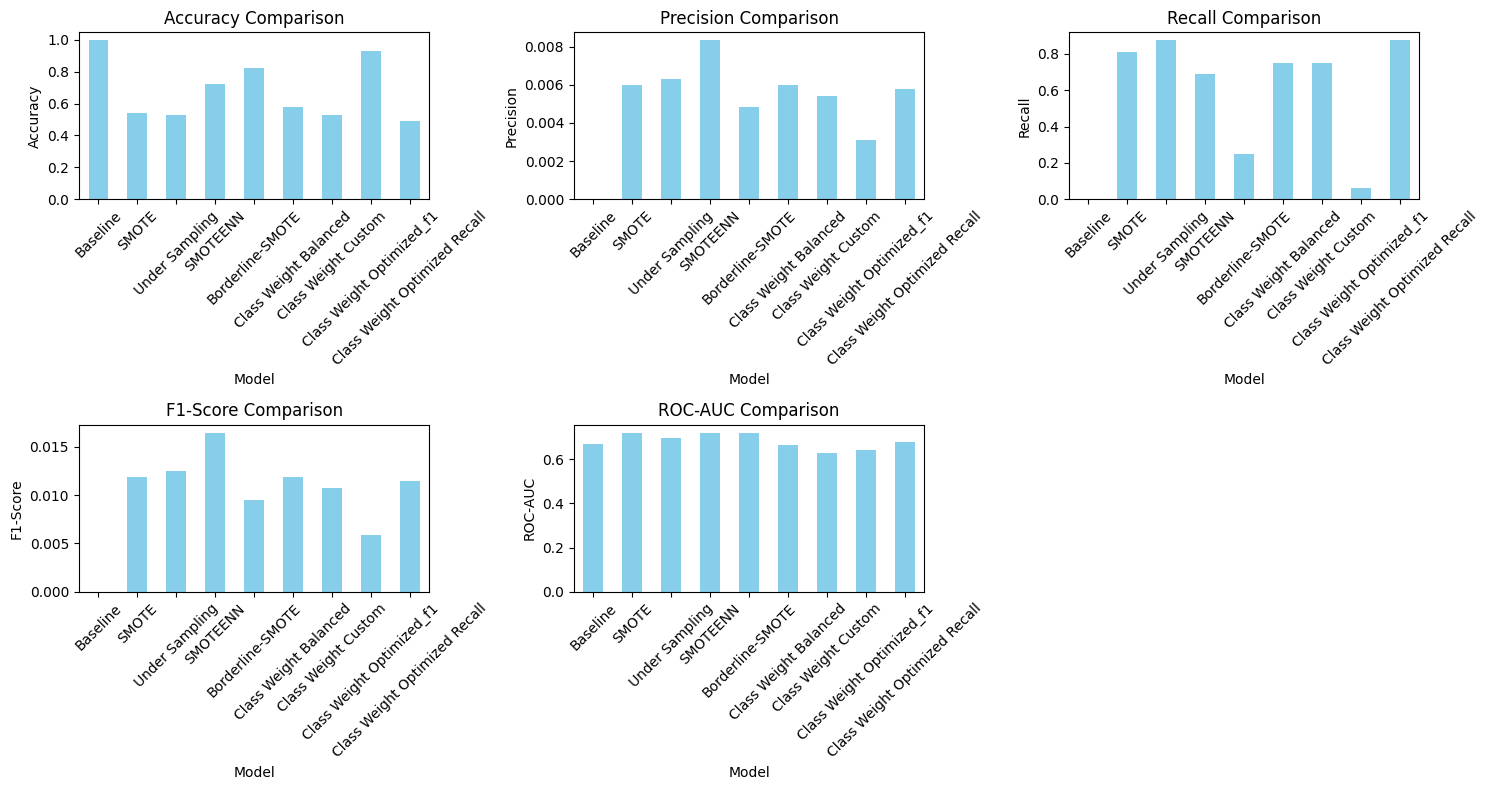

In [ ]:
# Bước 7: Đánh giá và so sánh models

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(model, X_test, y_test, model_name):
    """Hàm đánh giá model"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Các metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# Đánh giá tất cả models
results = []
for name, model in models.items():
    result = evaluate_model(model, X_test, y_test, name)
    results.append(result)
# Tạo DataFrame để so sánh
results_df = pd.DataFrame(results)
print("Kết quả đánh giá các models:")
print(results_df.round(4))

# Visualize kết quả
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for i, metric in enumerate(metrics):
    if i < len(axes):
        results_df.plot(x='Model', y=metric, kind='bar', ax=axes[i], color='skyblue')
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_xlabel('Model')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend().set_visible(False)

# Ẩn subplot thừa
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

CONFUSION MATRIX CHO TẤT CẢ CÁC PHƯƠNG PHÁP:


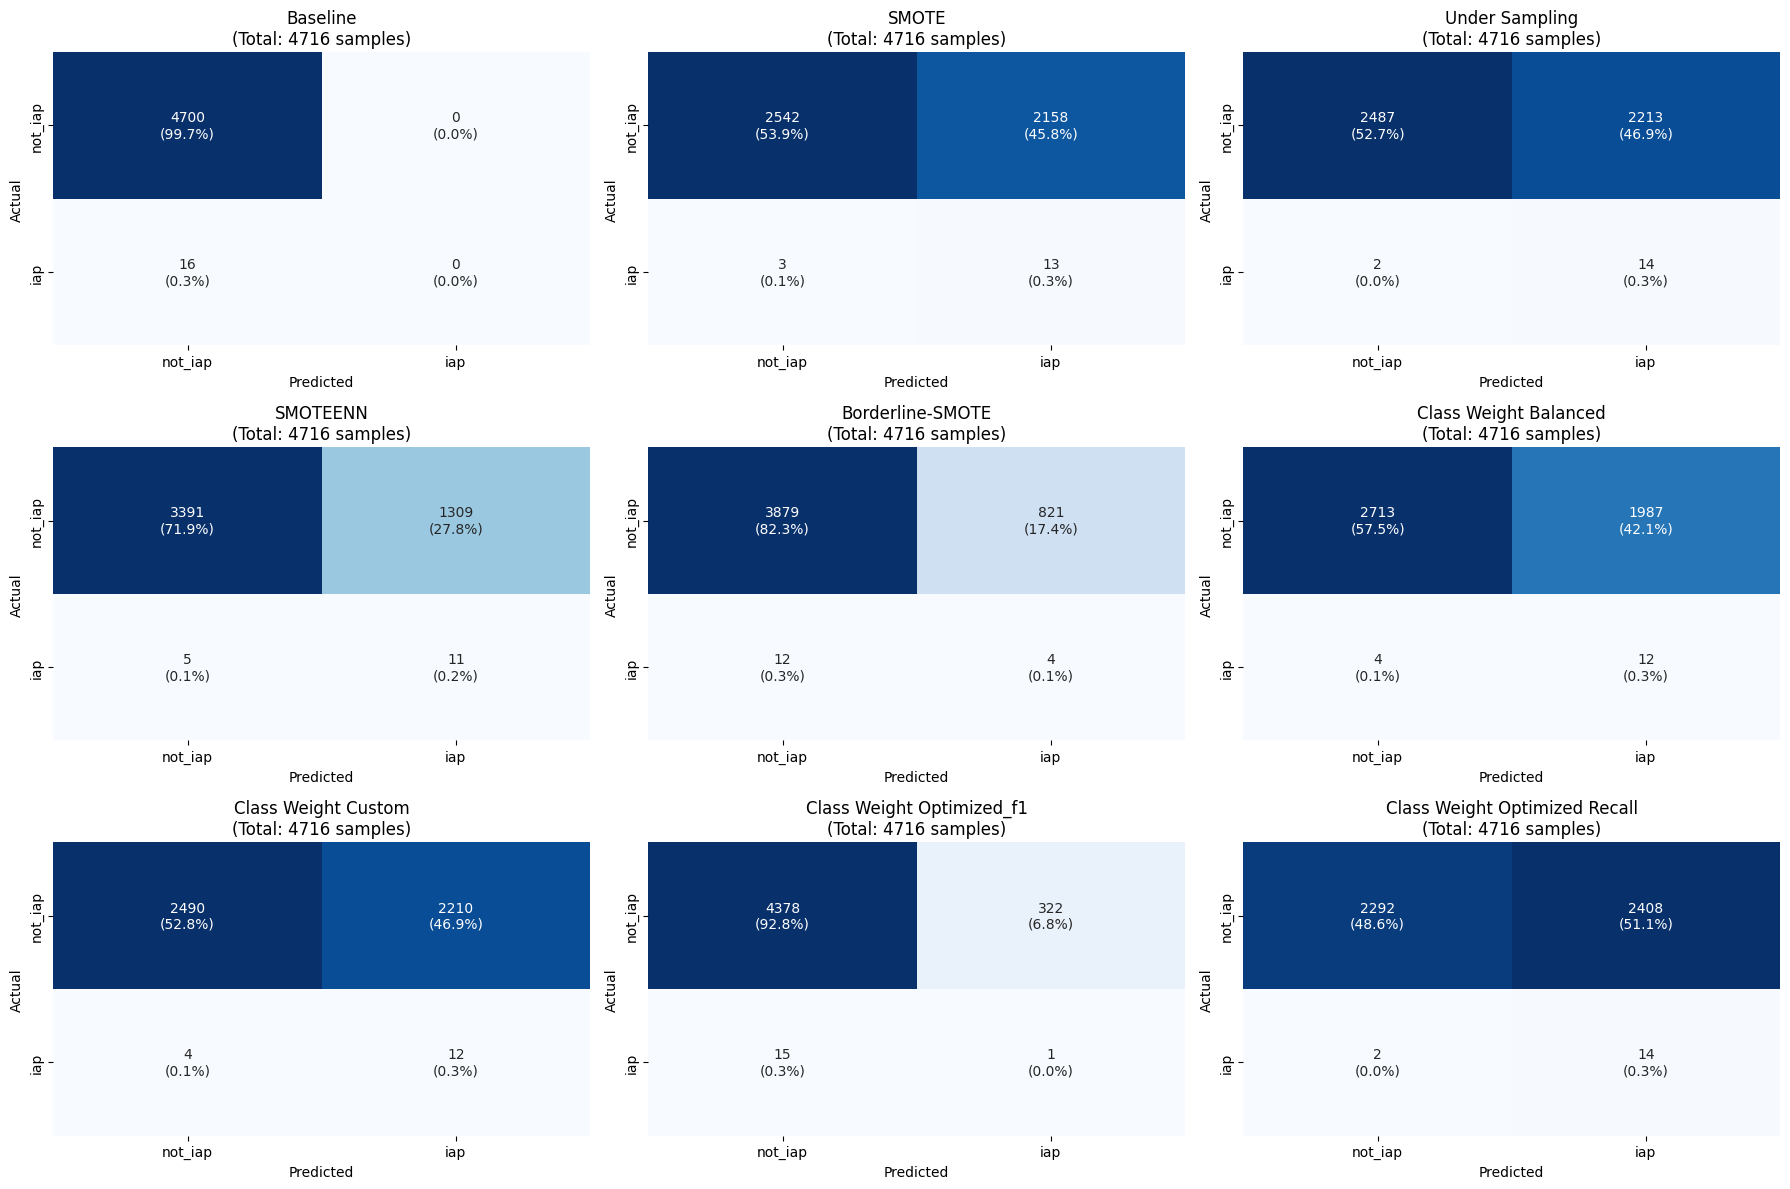

In [ ]:
# Code để hiển thị Confusion Matrix cho tất cả các phương pháp

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Danh sách nhãn (vì bạn đã tự làm target: not_iap=0, iap=1)
class_names = ['not_iap', 'iap']

# Tạo figure để hiển thị tất cả confusion matrices
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

print("CONFUSION MATRIX CHO TẤT CẢ CÁC PHƯƠNG PHÁP:")

# Duyệt qua tất cả models và tạo confusion matrix
for idx, (model_name, model) in enumerate(models.items()):
    # Predict trên test set
    y_pred = model.predict(X_test)
    # Tạo confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    # Tính tỷ lệ phần trăm
    total = cm.sum()
    # Visualize confusion matrix
    if idx < len(axes):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names,
                   ax=axes[idx], cbar=False)
        axes[idx].set_title(f'{model_name}\n(Total: {total} samples)')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

        # Thêm phần trăm vào ô
        for i in range(2):
            for j in range(2):
                text = axes[idx].texts[i*2 + j]
                text.set_text(f'{cm[i,j]}\n({cm[i,j]/total*100:.1f}%)')

# Ẩn subplot thừa nếu có
for idx in range(len(models), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


## Try đi try lại

Classification Report:
               precision    recall  f1-score   support

     not_iap       1.00      0.88      0.94      4723
         iap       0.02      0.65      0.04        17

    accuracy                           0.88      4740
   macro avg       0.51      0.77      0.49      4740
weighted avg       1.00      0.88      0.93      4740



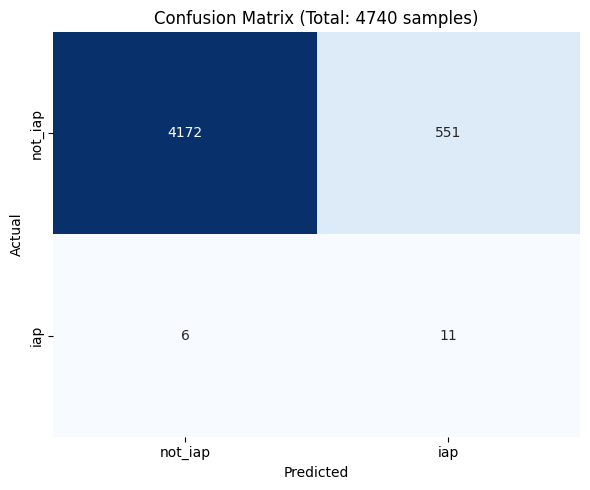

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ======= 1. Khởi tạo và huấn luyện mô hình ========
model = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight={0: 1, 1: 300
    }
)

model.fit(X_train_baseline, y_train_baseline)

# ======= 2. Dự đoán và đánh giá ========
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['not_iap', 'iap'])

# ======= 3. In classification report ========
print("Classification Report:\n", report)

# ======= 4. Vẽ Confusion Matrix ========
class_names = ['not_iap', 'iap']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title(f'Confusion Matrix (Total: {cm.sum()} samples)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


## Choose best model

In [ ]:
results_df

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Baseline,0.996607,0.000000,0.0000,0.000000,0.669681
1,SMOTE,0.541773,0.005988,0.8125,0.011888,0.719295
2,Under Sampling,0.530322,0.006286,0.8750,0.012483,0.696170
3,SMOTEENN,0.721374,0.008333,0.6875,0.016467,0.720346
4,Borderline-SMOTE,0.823367,0.004848,0.2500,0.009512,0.719441
5,Class Weight Balanced,0.577820,0.006003,0.7500,0.011911,0.663577
6,Class Weight Custom,0.530534,0.005401,0.7500,0.010724,0.630173
7,Class Weight Optimized_f1,0.928541,0.003096,0.0625,0.005900,0.643105
8,Class Weight Optimized Recall,0.488974,0.005780,0.8750,0.011485,0.679794



Confusion Matrix cho model: SMOTEENN
[[3391 1309]
 [   5   11]]

Classification Report cho model: SMOTEENN
              precision    recall  f1-score   support

     not_iap       1.00      0.72      0.84      4700
         iap       0.01      0.69      0.02        16

    accuracy                           0.72      4716
   macro avg       0.50      0.70      0.43      4716
weighted avg       1.00      0.72      0.83      4716



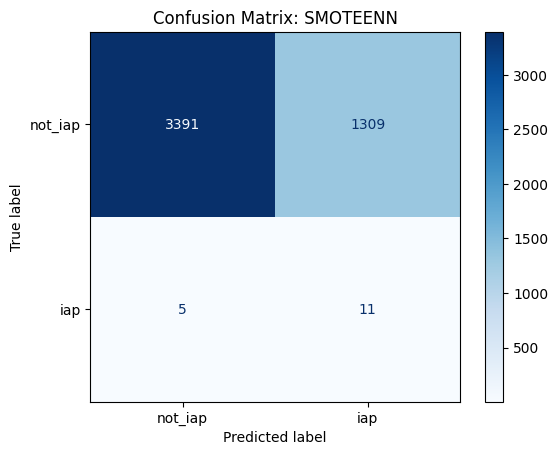

In [ ]:
# Chọn model thủ công (ví dụ: Under Sampling)
chosen_model_name = 'SMOTEENN'
chosen_model = models[chosen_model_name]

# Dự đoán và đánh giá
y_pred_manual = chosen_model.predict(X_test)

# In confusion matrix
print(f"\nConfusion Matrix cho model: {chosen_model_name}")
cm = confusion_matrix(y_test, y_pred_manual)
print(cm)

# Classification report
print(f"\nClassification Report cho model: {chosen_model_name}")
print(classification_report(y_test, y_pred_manual, target_names=['not_iap', 'iap']))

# Vẽ confusion matrix đẹp (nếu muốn)
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_manual,
    display_labels=['not_iap', 'iap'],
    cmap=plt.cm.Blues
)
plt.title(f'Confusion Matrix: {chosen_model_name}')
plt.show()


## Draw Tree

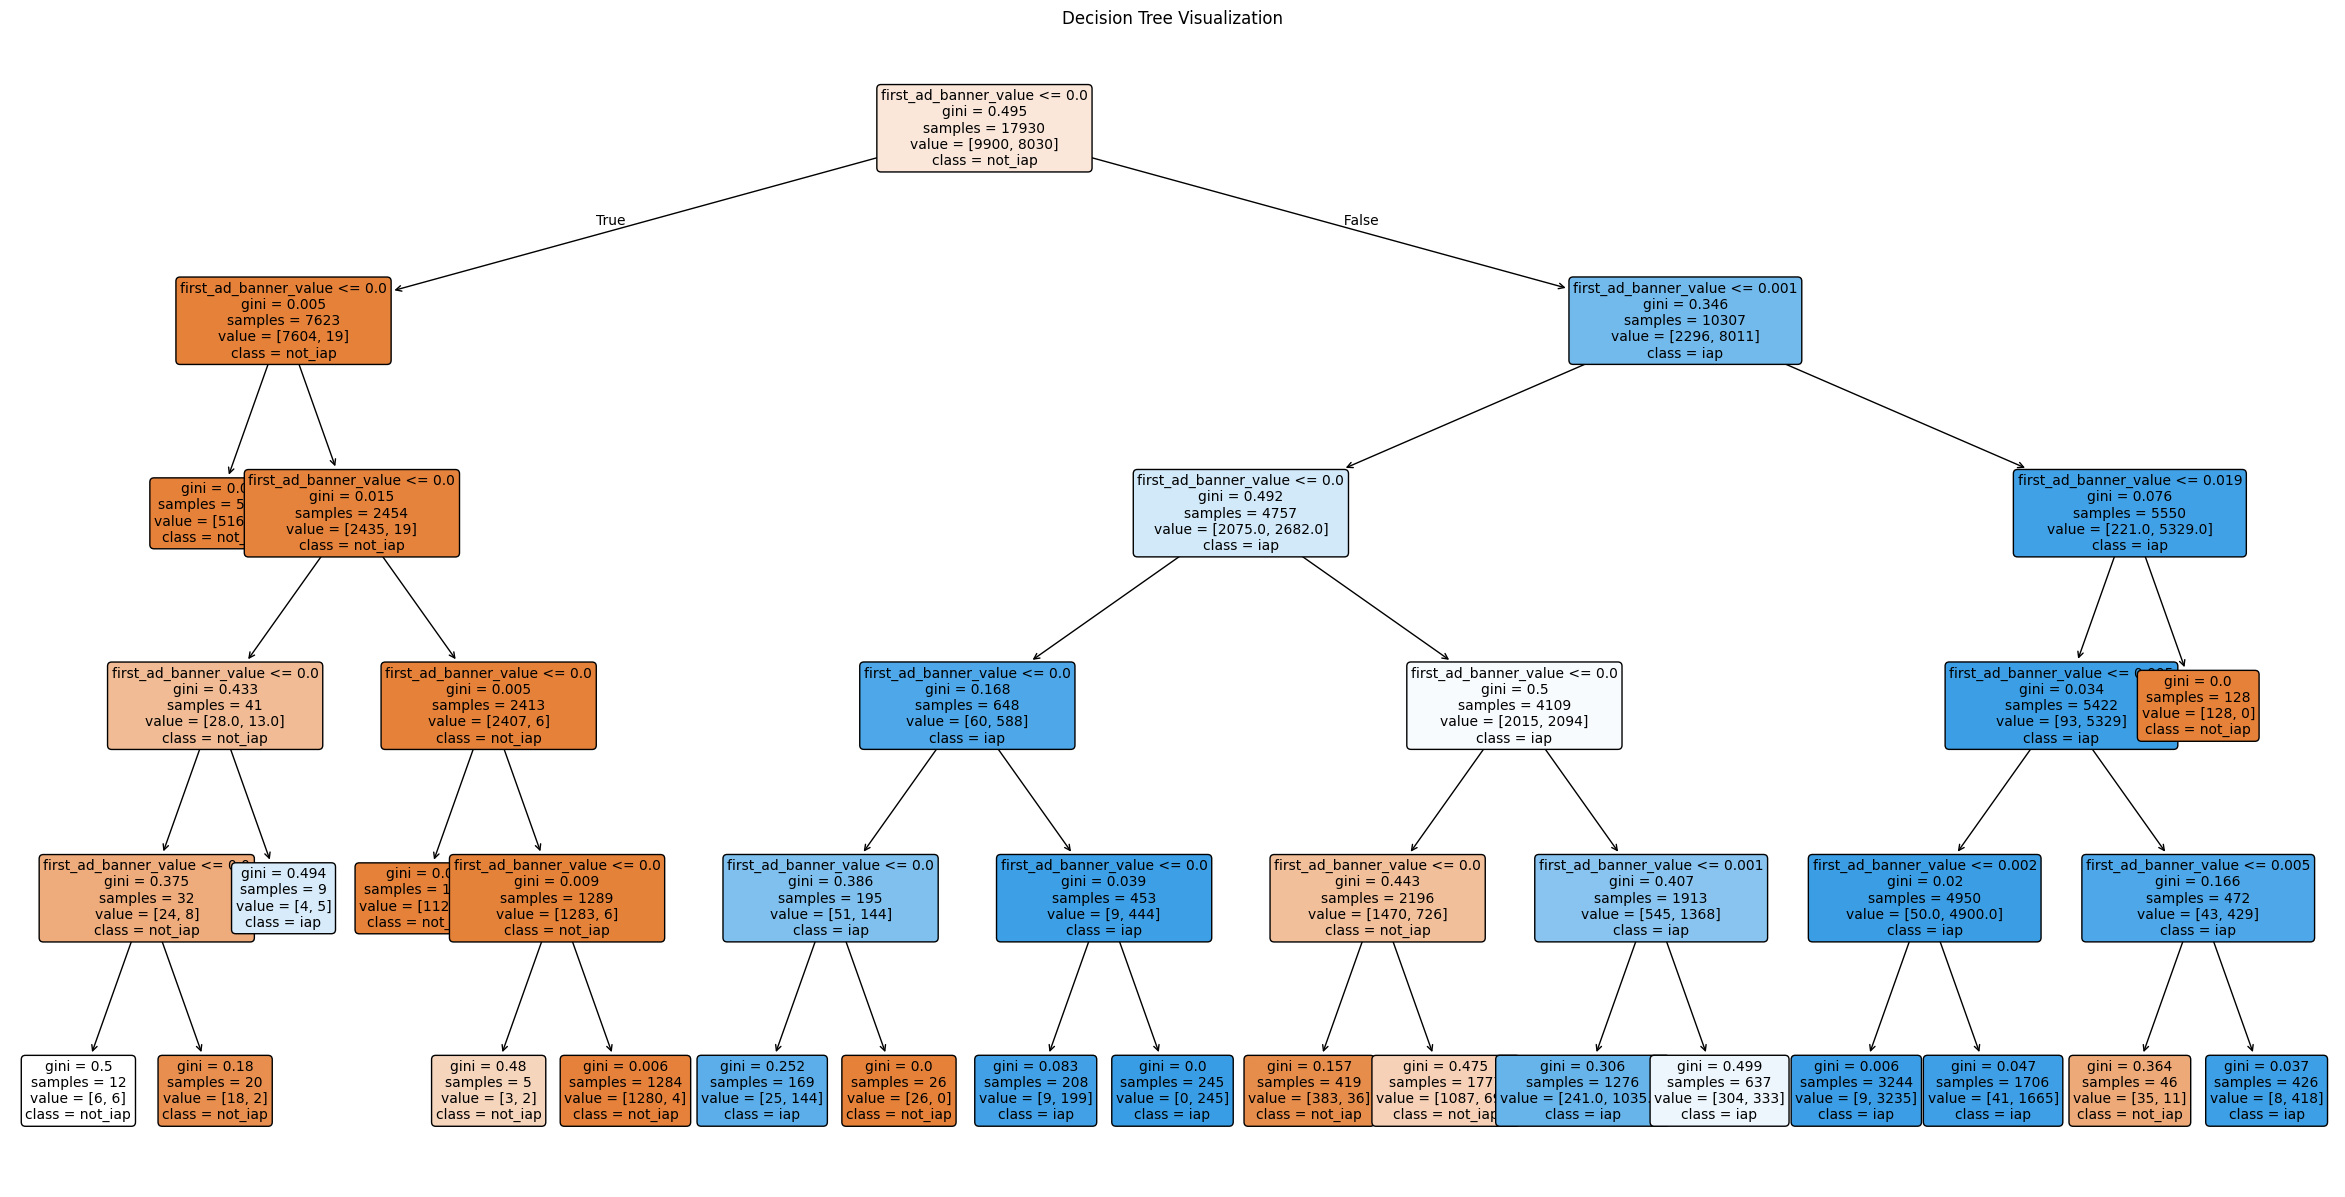

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Giả sử bạn có tên các cột features
feature_names = X_train.columns  # hoặc X_train.columns nếu phù hợp

# Vẽ cây
plt.figure(figsize=(30, 15))  # Kích thước lớn để thấy hết rule
plot_tree(
    chosen_model,
    feature_names=feature_names,
    class_names=['not_iap', 'iap'], # Thứ tự 0 -> 1
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Visualization")
plt.show()


In [ ]:
df_train_smoteenn = pd.concat([X_train_smoteenn, y_train_smoteenn], axis=1)


In [ ]:
filtered = df_train_smoteenn[
    (df_train_smoteenn['first_ad_banner_value'] <= 0.00021471415675478056) &
    (df_train_smoteenn['first_ad_banner_value'] > 0.00010354417463531718) &
    (df_train_smoteenn['first_ad_banner_value'] <= 0.0001059301066561602) &
    (df_train_smoteenn['first_ad_banner_value'] > 0.00010554722393862903)
]
filtered

,first_ad_banner_value,target
1836,0.000106,0
3568,0.000106,0
8064,0.000106,0
8890,0.000106,0
10467,0.000106,1
15460,0.000106,1
16156,0.000106,1
16818,0.000106,1
17250,0.000106,1


# Rule

## Iap Rule

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import _tree

def extract_iap_rules(model, feature_names, class_names, min_prob=0.5):
    """
    Trích xuất các rule dẫn tới class 'iap' từ cây decision tree
    Trả về DataFrame chứa các rule, xác suất, số lượng mẫu
    """
    tree = model.tree_
    rules = []

    def recurse(node, path, conditions):
        if tree.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[tree.feature[node]]
            threshold = tree.threshold[node]

            # Nhánh trái (<=)
            recurse(tree.children_left[node],
                    path + [f"{name} <= {threshold}"],
                    conditions + [(name, "<=", threshold)])

            # Nhánh phải (>)
            recurse(tree.children_right[node],
                    path + [f"{name} > {threshold:}"],
                    conditions + [(name, ">", threshold)])
        else:
            value = tree.value[node][0]
            total = np.sum(value)
            probs = value / total
            pred_class_id = int(np.argmax(value))
            pred_class = class_names[pred_class_id]

            if pred_class == 'iap' and probs[pred_class_id] >= min_prob:
                rules.append({
                    'rule': " AND ".join(path),
                    'predicted_class': pred_class,
                    'prob_iap': probs[1],  # class index 1 là iap
                    'prob_not_iap': probs[0],
                    'samples': int(total),
                    'iap_samples': int(value[1]),
                    'not_iap_samples': int(value[0])
                })

    recurse(0, [], [])
    return pd.DataFrame(rules)

# Gọi hàm:
iap_rules_df = extract_iap_rules(chosen_model, X_train.columns.tolist(), ['not_iap', 'iap'], min_prob=0.5)

iap_rules_df


,rule,predicted_class,prob_iap,prob_not_iap,samples,iap_samples,not_iap_samples
0,first_ad_banner_value <= 0.0002147141567547805...,iap,0.555556,0.444444,1,0,0
1,first_ad_banner_value > 0.00021471415675478056...,iap,0.852071,0.147929,1,0,0
2,first_ad_banner_value > 0.00021471415675478056...,iap,0.956731,0.043269,1,0,0
3,first_ad_banner_value > 0.00021471415675478056...,iap,1.000000,0.000000,1,1,0
4,first_ad_banner_value > 0.00021471415675478056...,iap,0.811129,0.188871,1,0,0
5,first_ad_banner_value > 0.00021471415675478056...,iap,0.522763,0.477237,1,0,0
6,first_ad_banner_value > 0.00021471415675478056...,iap,0.997226,0.002774,1,0,0
7,first_ad_banner_value > 0.00021471415675478056...,iap,0.975967,0.024033,1,0,0
8,first_ad_banner_value > 0.00021471415675478056...,iap,0.981221,0.018779,1,0,0


In [ ]:
import pandas as pd
import re

def simplify_rule(rule_str, feature_name='first_ad_banner_value '):
    # Tìm tất cả điều kiện
    conditions = re.findall(rf"{feature_name}\s*(<=|>)\s*([0-9\.]+)", rule_str)

    lower_bounds = []
    upper_bounds = []

    for op, val in conditions:
        val = float(val)
        if op == '>':
            lower_bounds.append(val)
        elif op == '<=':
            upper_bounds.append(val)

    # Tìm khoảng ghép
    if lower_bounds:
        lower = max(lower_bounds)
    else:
        lower = None

    if upper_bounds:
        upper = min(upper_bounds)
    else:
        upper = None

    # Ghép lại
    if lower is not None and upper is not None:
        return f"{lower} < {feature_name} <= {upper:.5f}"
    elif lower is not None:
        return f"{feature_name} > {lower:.5f}"
    elif upper is not None:
        return f"{feature_name} <= {upper:.5f}"
    else:
        return "UNKNOWN"

# Áp dụng vào cột rule
iap_rules_df['simplified_rule'] = iap_rules_df['rule'].apply(simplify_rule)


In [ ]:
iap_rules_df[['simplified_rule','predicted_class','prob_not_iap','prob_iap']]

,simplified_rule,predicted_class,prob_not_iap,prob_iap
0,0.00010554722393862903 < first_ad_banner_value...,iap,0.444444,0.555556
1,0.00021471415675478056 < first_ad_banner_value...,iap,0.147929,0.852071
2,0.00021871111675864086 < first_ad_banner_value...,iap,0.043269,0.956731
3,0.00022371773957274854 < first_ad_banner_value...,iap,0.000000,1.000000
4,0.0004165281425230205 < first_ad_banner_value ...,iap,0.188871,0.811129
5,0.0006012547528371215 < first_ad_banner_value ...,iap,0.477237,0.522763
6,0.0010129925794899464 < first_ad_banner_value ...,iap,0.002774,0.997226
7,0.0017517607193440199 < first_ad_banner_value ...,iap,0.024033,0.975967
8,0.0050016362220048904 < first_ad_banner_value ...,iap,0.018779,0.981221


### Đánh giá trên df_train

In [ ]:
import pandas as pd

def evaluate_rules_on_df(iap_rules_df, df_train, rule_col='simplified_rule', target_col='target'):
    """
    Lọc lại từng rule từ iap_rules_df trong df_train gốc,
    trả ra DataFrame gồm các cột: rule, predicted_class, samples, sample_iap, sample_not_iap, prob_iap, prob_not_iap
    """
    results = []

    for _, row in iap_rules_df.iterrows():
        rule_str = row[rule_col]
        predicted_class = row['predicted_class']

        # Chuyển rule dạng chuỗi thành biểu thức lọc pandas
        try:
            filtered_df = df_train.query(rule_str)
        except Exception as e:
            print(f"Lỗi khi parse rule: {rule_str} → {e}")
            continue

        total = len(filtered_df)
        sample_iap = filtered_df[filtered_df[target_col] == 1].shape[0]
        sample_not_iap = filtered_df[filtered_df[target_col] == 0].shape[0]
        prob_iap = sample_iap / total if total > 0 else 0
        prob_not_iap = 1 - prob_iap if total > 0 else 0

        results.append({
            'simplified_rule': rule_str,
            'predicted_class': predicted_class,
            'samples': total,
            'sample_iap': sample_iap,
            'sample_not_iap': sample_not_iap,
            'prob_iap': prob_iap,
            'prob_not_iap': prob_not_iap
        })

    return pd.DataFrame(results)

In [ ]:
df_train = pd.concat([X_train, y_train], axis=1)

In [ ]:
validated_rules_df = evaluate_rules_on_df(iap_rules_df, df_train)
validated_rules_df

,simplified_rule,predicted_class,samples,sample_iap,sample_not_iap,prob_iap,prob_not_iap
0,0.00010554722393862903 < first_ad_banner_value...,iap,253,1,252,0.003953,0.996047
1,0.00021471415675478056 < first_ad_banner_value...,iap,183,2,181,0.010929,0.989071
2,0.00021871111675864086 < first_ad_banner_value...,iap,26,0,26,0.000000,1.000000
3,0.00022371773957274854 < first_ad_banner_value...,iap,138,2,136,0.014493,0.985507
4,0.0004165281425230205 < first_ad_banner_value ...,iap,1661,10,1651,0.006020,0.993980
5,0.0006012547528371215 < first_ad_banner_value ...,iap,1549,6,1543,0.003873,0.996127
6,0.0010129925794899464 < first_ad_banner_value ...,iap,846,16,830,0.018913,0.981087
7,0.0017517607193440199 < first_ad_banner_value ...,iap,615,9,606,0.014634,0.985366
8,0.0050016362220048904 < first_ad_banner_value ...,iap,143,3,140,0.020979,0.979021


## Not Iap Rule

In [ ]:
def extract_not_iap_rules(model, feature_names, class_names, min_prob=0.5):
    """
    Trích xuất các rule dẫn tới class 'not_iap' từ cây decision tree
    Trả về DataFrame chứa các rule, xác suất, số lượng mẫu
    """
    tree = model.tree_
    rules = []

    def recurse(node, path, conditions):
        if tree.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[tree.feature[node]]
            threshold = tree.threshold[node]

            # Nhánh trái (<=)
            recurse(tree.children_left[node],
                    path + [f"{name} <= {threshold}"],
                    conditions + [(name, "<=", threshold)])

            # Nhánh phải (>)
            recurse(tree.children_right[node],
                    path + [f"{name} > {threshold}"],
                    conditions + [(name, ">", threshold)])
        else:
            value = tree.value[node][0]
            total = np.sum(value)
            probs = value / total
            pred_class_id = int(np.argmax(value))
            pred_class = class_names[pred_class_id]

            if pred_class == 'not_iap' and probs[pred_class_id] >= min_prob:
                rules.append({
                    'rule': " AND ".join(path),
                    'predicted_class': pred_class,
                    'prob_not_iap': probs[0],  # class index 0 là not_iap
                    'prob_iap': probs[1],
                    'samples': int(total),
                    'not_iap_samples': int(value[0]),
                    'iap_samples': int(value[1])
                })

    recurse(0, [], [])
    return pd.DataFrame(rules)
not_iap_rules_df = extract_not_iap_rules(
    model=chosen_model,
    feature_names=X_train.columns.tolist(),
    class_names=['not_iap', 'iap'],
    min_prob=0.5  # hoặc 0.8 nếu muốn chỉ lấy các node chắc chắn hơn
)

not_iap_rules_df


,rule,predicted_class,prob_not_iap,prob_iap,samples,not_iap_samples,iap_samples
0,first_ad_banner_value <= 0.0002147141567547805...,not_iap,1.000000,0.000000,1,1,0
1,first_ad_banner_value <= 0.0002147141567547805...,not_iap,0.500000,0.500000,1,0,0
2,first_ad_banner_value <= 0.0002147141567547805...,not_iap,0.900000,0.100000,1,0,0
3,first_ad_banner_value <= 0.0002147141567547805...,not_iap,1.000000,0.000000,1,1,0
4,first_ad_banner_value <= 0.0002147141567547805...,not_iap,0.600000,0.400000,1,0,0
5,first_ad_banner_value <= 0.0002147141567547805...,not_iap,0.996885,0.003115,1,0,0
6,first_ad_banner_value > 0.00021471415675478056...,not_iap,1.000000,0.000000,1,1,0
7,first_ad_banner_value > 0.00021471415675478056...,not_iap,0.914081,0.085919,1,0,0
8,first_ad_banner_value > 0.00021471415675478056...,not_iap,0.611705,0.388295,1,0,0
9,first_ad_banner_value > 0.00021471415675478056...,not_iap,0.760870,0.239130,1,0,0


In [ ]:
import re

def simplify_rule(rule_str, feature_name='first_ad_banner_value'):
    # Tách các điều kiện trong chuỗi
    conditions = re.findall(rf"{feature_name}\s*(<=|>)\s*([0-9\.]+)", rule_str)

    lower_bounds = []
    upper_bounds = []

    for op, val in conditions:
        val = float(val)
        if op == '>':
            lower_bounds.append(val)
        elif op == '<=':
            upper_bounds.append(val)

    lower = max(lower_bounds) if lower_bounds else None
    upper = min(upper_bounds) if upper_bounds else None

    if lower is not None and upper is not None:
        return f"{lower:.5f} < {feature_name} <= {upper:}"
    elif lower is not None:
        return f"{feature_name} > {lower:}"
    elif upper is not None:
        return f"{feature_name} <= {upper:}"
    else:
        return "UNKNOWN"
not_iap_rules_df['simplified_rule'] = not_iap_rules_df['rule'].apply(simplify_rule)
def extract_not_iap_prob(prob_str):
    match = re.search(r'not_iap:\s*([0-9\.]+)', prob_str)
    return float(match.group(1)) if match else None

not_iap_rules_df[['simplified_rule','predicted_class','prob_not_iap','prob_iap']]


,simplified_rule,predicted_class,prob_not_iap,prob_iap
0,first_ad_banner_value <= 0.00010354417463531718,not_iap,1.000000,0.000000
1,0.00010 < first_ad_banner_value <= 0.000103906...,not_iap,0.500000,0.500000
2,0.00010 < first_ad_banner_value <= 0.000105547...,not_iap,0.900000,0.100000
3,0.00011 < first_ad_banner_value <= 0.000140234...,not_iap,1.000000,0.000000
4,0.00014 < first_ad_banner_value <= 0.000140357...,not_iap,0.600000,0.400000
5,0.00014 < first_ad_banner_value <= 0.000214714...,not_iap,0.996885,0.003115
6,0.00022 < first_ad_banner_value <= 0.000218711...,not_iap,1.000000,0.000000
7,0.00023 < first_ad_banner_value <= 0.000251543...,not_iap,0.914081,0.085919
8,0.00025 < first_ad_banner_value <= 0.000416528...,not_iap,0.611705,0.388295
9,0.00481 < first_ad_banner_value <= 0.005001636...,not_iap,0.760870,0.239130


In [ ]:
validated_rules_df = evaluate_rules_on_df(not_iap_rules_df, df_train)
validated_rules_df

,simplified_rule,predicted_class,samples,sample_iap,sample_not_iap,prob_iap,prob_not_iap
0,first_ad_banner_value <= 0.00010354417463531718,not_iap,5169,0,5169,0.000000,1.000000
1,0.00010 < first_ad_banner_value <= 0.000103906...,not_iap,238,1,237,0.004202,0.995798
2,0.00010 < first_ad_banner_value <= 0.000105547...,not_iap,324,1,323,0.003086,0.996914
3,0.00011 < first_ad_banner_value <= 0.000140234...,not_iap,1456,0,1456,0.000000,1.000000
4,0.00014 < first_ad_banner_value <= 0.000140357...,not_iap,18,0,18,0.000000,1.000000
5,0.00014 < first_ad_banner_value <= 0.000214714...,not_iap,2551,2,2549,0.000784,0.999216
6,0.00022 < first_ad_banner_value <= 0.000218711...,not_iap,0,0,0,0.000000,0.000000
7,0.00023 < first_ad_banner_value <= 0.000251543...,not_iap,736,2,734,0.002717,0.997283
8,0.00025 < first_ad_banner_value <= 0.000416528...,not_iap,3278,11,3267,0.003356,0.996644
9,0.00481 < first_ad_banner_value <= 0.005001636...,not_iap,52,0,52,0.000000,1.000000


# Regard on different day

In [ ]:
start_date = '2025-06-01'
end_date = '2025-06-09'

In [ ]:
query = f"""
with user_iap as (
  select distinct user_pseudo_id
  FROM `crazy-coffee-jam.flatten_table.in_app_purchase`
  WHERE event_date between '{start_date}' and '{end_date}'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date between '{start_date}' and '{end_date}')
), first_ad_banner_time as (
  select user_pseudo_id, min(event_timestamp) as first_banner_time
  from `crazy-coffee-jam.flatten_table.ad_impression`
  WHERE event_date between '{start_date}' and '{end_date}'
  and ad_format = 'BANNER'
  and user_pseudo_id in (select distinct user_pseudo_id from `crazy-coffee-jam.flatten_table.first_open` where event_date between '{start_date}' and '{end_date}')
  group by user_pseudo_id
)
select a.user_pseudo_id, b.value as first_ad_banner_value,
 case when a.user_pseudo_id in (select distinct user_pseudo_id from user_iap) then 'iap' else 'not_iap' end as user_label
from first_ad_banner_time a
left join `crazy-coffee-jam.flatten_table.ad_impression` b
on a.user_pseudo_id = b.user_pseudo_id
and a.first_banner_time = b.event_timestamp
"""
df_new_days = client.query(query).to_dataframe()
df_new_days.drop_duplicates(subset=['user_pseudo_id'], inplace=True)
df_new_days['user_label'].value_counts()

,count
user_label,
not_iap,8986
iap,15


              precision    recall  f1-score   support

     not_iap       1.00      0.78      0.88      8986
         iap       0.01      0.80      0.01        15

    accuracy                           0.78      9001
   macro avg       0.50      0.79      0.45      9001
weighted avg       1.00      0.78      0.88      9001



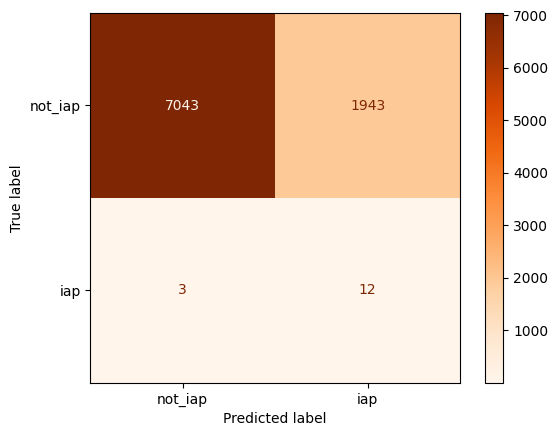

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Bỏ các cột không dùng
X_new = df_new_days.drop(columns=['user_label', 'user_pseudo_id'], errors='ignore')

# Map label thủ công: 'not_iap' → 0, 'iap' → 1
y_true = df_new_days['user_label'].map({'not_iap': 0, 'iap': 1})
y_pred = chosen_model.predict(X_new)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not_iap', 'iap'])
disp.plot(cmap='Oranges', values_format='d')

# Classification report
print(classification_report(y_true, y_pred, target_names=['not_iap', 'iap']))
